In [9]:
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt



In [10]:
def create_model():
    inputs = Input(shape=(28, 28))
    x = Flatten()(inputs)
    x = Dense(128, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    return Model(inputs, outputs)

In [11]:
def train_step(model, images, labels, optimizer, loss_fn):
    with tf.GradientTape() as tape:
        preds = model(images, training=True)
        loss = loss_fn(labels, preds)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [12]:
(x_train, y_train), (x_test, y_test) = load_data()
x_train, x_test = x_train/255.0, x_test/255.0
y_train = to_categorical(y_train, 10)
y_test  = to_categorical(y_test, 10)

epochs = 5

In [13]:
gt_model   = create_model()
optimizer  = Adam(0.001)
loss_fn    = CategoricalCrossentropy()
gt_losses  = []
gt_accs     = []

In [14]:
for ep in range(epochs):
    ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(60000).batch(32)
    m_loss = tf.keras.metrics.Mean()
    for imgs, lbls in ds:
        l = train_step(gt_model, imgs, lbls, optimizer, loss_fn)
        m_loss.update_state(l)
    gt_losses.append(m_loss.result().numpy())
    m_acc = tf.keras.metrics.CategoricalAccuracy()
    for imgs, lbls in tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32):
        preds = gt_model(imgs, training=False)
        m_acc.update_state(lbls, preds)
    gt_accs.append(m_acc.result().numpy())

In [19]:
fit_model = create_model()
hist = fit_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
hist = fit_model.fit(x_train, y_train,epochs=epochs,batch_size=32,validation_data=(x_test, y_test),verbose=0)
fit_losses = hist.history['loss']
fit_val_accs = hist.history['val_accuracy']

In [20]:
print(f'Custom Training Accuracy: {gt_accs[-1]:.4f}')
print(f'Fit Training Accuracy: {fit_val_accs[-1]:.4f}')

Custom Training Accuracy: 0.9789
Fit Training Accuracy: 0.9694


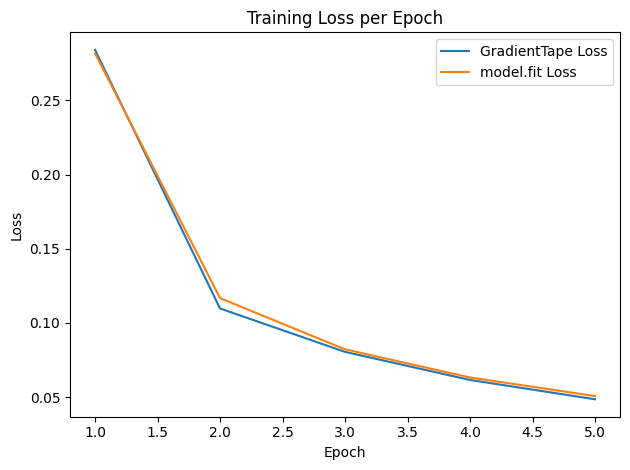

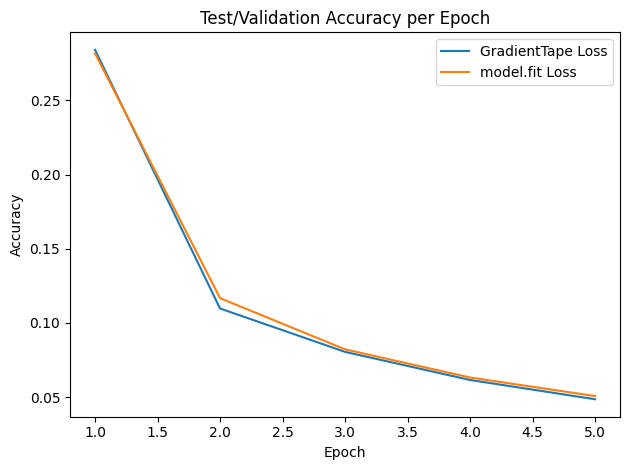

In [18]:


plt.figure()
plt.plot(range(1, epochs+1), gt_losses, label='GradientTape Loss')
plt.plot(range(1, epochs+1), fit_losses, label='model.fit Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(range(1, epochs+1), gt_losses, label='GradientTape Loss')
plt.plot(range(1, epochs+1), fit_losses, label='model.fit Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test/Validation Accuracy per Epoch')
plt.legend()
plt.tight_layout()